# Understanding the code and loss funtion

refs:
* https://github.com/TeaPearce/Deep_Learning_Prediction_Intervals
* https://arxiv.org/pdf/1802.07167.pdf
    * High-Quality Prediction Intervals for Deep Learning: A Distribution-Free, Ensembled Approach

**Goals**

* Understand mpiw vs coverage term and pcip 
    * The model minimize first coverage term and then start minimize mpiw by decreasing PCIP?
    * WHta happened if initial parameters start with very low PCIP? It is better start with PICP 100%?
    * Why divide y by 5? in the original code

* Work linear regression wher you control the error
    * learn how to sacrifies picp to have narrow pi

## Notes

**findings** 

* mpiw vs coverage term behavor
    1. DNN set a wide pi range, picp become 1.00 
    1. Then the optmization try to reduce mpiw
    1. when mpiw start to become as narrow as possible, picp increase alittle bit
    
* Trade mpiw per picip.
    * It is not possible ot trade mpiw per pcip. Once the algo get the region where coverage terms is constant ans equal zero, it cannot recovery for that reagion anymore. Intiuition is related to derivatives equal to zero
    * Or it is very hard to get that

In [2]:
import IPython
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras
from keras import backend as K
import tensorflow as tf

In [4]:
from utils import qd_objective, mpiw_pct, mpiw, picp,mpiw_pct_metric, mpiw_metric,picp_metric

In [5]:
from pathlib import Path 
import sys
# printing all paths
sys.path

# appending a path
repo = '/home/ubuntu/leandro-algopricing-analytics'
sys.path.append(repo)

import pandas as pd

['/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '',
 '/home/ubuntu/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/ubuntu/.local/lib/python3.6/site-packages/IPython/extensions',
 '/home/ubuntu/.ipython']

## Load data

In [5]:
def _min_max_with_missing(x: pd.Series, _min=None, _max=None) -> pd.Series:
    
    # missing = -1
    x_no_missing = x[x >= 0]
    
    if _min is None:
        
        _min = x_no_missing.min()
        
    if _max is None:
        _max = x_no_missing.max()

    x_normalized = x.map(lambda value: -1 if value < 0 else (value - _min)/(_max - _min)  ) 
    
    return x_normalized

In [6]:
fname = Path("data") / "2022-06-16-lhof-target_data_one_model.csv"
processed_data = pd.read_csv(fname, index_col=False)

In [7]:
# see EDA on 1_2022_06_13-lhof-feature_engineer_one_asset_model

processed_data.shape

# miles utliers (-5 samples)
processed_data = processed_data[processed_data.meter_reading < 0.60*1e6]

# ages outliers
processed_data = processed_data[processed_data.item_age_yrs < 27]

# bad data
criteria = (processed_data.high_bid_usd > 2500) & (processed_data.high_bid_usd < 50000)
processed_data = processed_data[criteria]

normalized_data = processed_data.copy()

normalized_data['norm_miles'] = _min_max_with_missing(normalized_data.meter_reading,_min=None, _max=0.60*1e6)
normalized_data['norm_ages'] = _min_max_with_missing(normalized_data.item_age_yrs,_min=None, _max=30)

normalized_data['norm_month'] = _min_max_with_missing(normalized_data.month,_min=0, _max=12)

normalized_data['norm_year'] = _min_max_with_missing(normalized_data.year,_min=2018, _max=2022)

normalized_data['norm_y'] = _min_max_with_missing(normalized_data.high_bid_usd)

(7299, 25)

In [8]:
prices = normalized_data.high_bid_usd
prices = normalized_data.norm_y

prices.min()
prices.mean()
np.median(prices)
prices.max()
prices.std()

0.0

0.14754511196093834

0.11748093758825191

1.0

0.13070053035773366

In [9]:
X = np.array(normalized_data.norm_miles.to_list())

X.shape
X.min()
X.mean()
np.median(X)
X.max()
X.std()

(6182,)

0.0

0.2798692599482368

0.27912166666666666

0.9609983333333333

0.12548210471133653

In [10]:
# create some data
n_samples = 512
n_ = n_samples
#X = np.random.uniform(low=-2.,high=2.,size=(n_samples,1))

#noise = 3000*np.random.normal(loc=0.,scale=(1.0 - np.power(X,2)))
noise = 0.13*np.random.normal(loc=0.,scale=(1.0 - np.power(X,2)))

#y = 45000*np.cos(np.pi*X/2.0) + 7500 + noise
y = 0.96*np.cos(np.pi*X/2.0) + 0.12 + noise

y = y.reshape([-1,1])/5.

X_train = X.reshape(-1)
y_train = y.reshape(-1)

y_train = np.stack((y_train,y_train),axis=1) # make this 2d so will be accepted
x_grid = np.linspace(0.0,1.0,100) # for evaluation plots

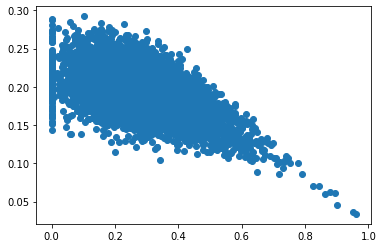

In [11]:
plt.scatter(X_train,y_train[:,0])

In [6]:
def graph_pi_report(result):
    
    result_loss =np.array(result.history['loss']).reshape(-1)

    result_loss.shape
    #result_loss = np.array(result.history['loss']).reshape(-1)

    print(f"loss last 5 values: {result_loss[-6:-1]}")

    x = range(result_loss.shape[0])
    plt.plot(x, result_loss, label='train')
    plt.title('Loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.ylim(0,6)
    plt.show()
 
    # view training
    result_mpiw = np.array(result.history['mpiw_metric']).reshape(-1)
    result_coverage_term = np.array(result.history['coverage_term_metric']).reshape(-1)

    print(f"Init guess => mpiw: {result_mpiw[0]}; coverage_term: {result_coverage_term[0]}")
    print(f"Last values => mpiw: {result_mpiw[-1]}; coverage_term: {result_coverage_term[-1]}")

    fig, ax1 = plt.subplots()
    x = range(result_mpiw.shape[0])

    ax2 = ax1.twinx()
    ax1.plot(x, result_mpiw, label='mpiw_metric', color='b')
    ax2.plot(x, result_coverage_term,label='coverage_term_metric',color='g')

    # ax1.set_xlabel('X data')
    ax1.set_ylabel('mpiw_metric', color='b')
    ax2.set_ylabel('coverage_term_metric', color='g')

    # plt.plot(x, result_mpiw, color='b',  label='mpiw_metric') # upper boundary prediction
    # plt.plot(x, result_coverage_term, color='g', label='coverage_term_metric') # lower boundary prediction

    #plt.legend()
    plt.show()

    # view training
    result_mpiw = np.array(result.history['mpiw_metric']).reshape(-1)
    result_picp = np.array(result.history['picp_metric_']).reshape(-1)

    print(f"Init guess => mpiw: {result_mpiw[0]}; picp: {result_picp[0]}")
    print(f"Last values => mpiw: {result_mpiw[-1]}; picp: {result_picp[-1]}")

    fig, ax1 = plt.subplots()

    x = range(result_mpiw.shape[0])

    ax2 = ax1.twinx()
    ax1.plot(x, result_mpiw, label='mpiw_metric', color='b')
    ax2.plot(x, result_picp,label='picp_metric_',color='g')

    # ax1.set_xlabel('X data')
    ax1.set_ylabel('mpiw_metric', color='b')
    ax2.set_ylabel('picp_metric_', color='g')

    plt.show()

    
def pi_performance_report(y_true,y_pred):

    PICP = picp(y_true,y_pred)

    MPIW = mpiw(y_true,y_pred)

    mean_prices = np.mean(y_true[:,0])

    print(f'PICP: {PICP:.2f}')
    print(f'MPIW/2.0: {MPIW/2.0:.2f}; y_mean: {mean_prices:.2f}; cv: {MPIW/2.0/mean_prices:.2f}')
    
    return MPIW, PICP

In [13]:
# hyperparameters
lambda_ = 0.01*100.00 # lambda in loss fn
alpha_ = 0.40  # capturing (1-alpha)% of samples
soften_ = 160.
n_ = n_samples # batch size

n_

def loss_qd(y_true, y_pred):

    return qd_objective(y_true, y_pred,n_, lambda_, alpha_, soften_)


def picp_metric_(y_true, y_pred):
    
    return picp_metric(y_true, y_pred, soften_=soften_)

def coverage_term_metric(y_true, y_pred):
    
    y_true = y_true[:,0]

    y_u = y_pred[:,0]
    y_l = y_pred[:,1]

    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)
    
    PICP_S = tf.reduce_mean(K_S)

    coverage_term = lambda_ * n_ / (alpha_*(1-alpha_)) * tf.maximum(0.,(1-alpha_) - PICP_S)
    
    return coverage_term

512

In [ ]:
# set up model
model = Sequential()
model.add(Dense(100, input_dim=1, activation='relu',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)))
model.add(Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3), 
                bias_initializer=keras.initializers.Constant(value=[0.3,0.05]))) # important to init biases to start!

# compile
opt = keras.optimizers.Adam(lr=0.02, decay=0.005)
model.compile(loss=qd_objective, optimizer=opt, metrics=[mpiw_metric,coverage_term_metric,picp_metric_])

In [ ]:
# plot and view some predictions
y_pred = model.predict(x_grid, verbose=0)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]

plt.scatter(X_train,y_train[:,0])
plt.plot(x_grid, y_u_pred, color='r') # upper boundary prediction
plt.plot(x_grid, y_l_pred, color='g') # lower boundary prediction
plt.title('BEFORE training')
#plt.xlim(-2,2)
plt.show()

In [ ]:
# print some stats
y_pred = model.predict(X_train, verbose=0)

pi_performance_report(y_train,y_pred)

print("loss")
loss_qd(y_train, y_pred)
print("mpiw")
mpiw_metric(y_train, y_pred)
print("coverage related term")
coverage_term_metric(y_train, y_pred)
print("picp")
picp_metric_(y_train, y_pred)

In [ ]:

#result = model.fit(X_train, y_train, epochs=11, batch_size=n_, verbose=1,  validation_split=0.)
result_loss=[]
mpiw_list = []
coverage_list = []
loss_list = []
pcip_list = []
for i in range(5):
    
    result = model.fit(X_train, y_train, epochs=10, batch_size=n_, verbose=0,  validation_split=0.)
    result_loss.append(result.history['loss'])

    y_pred = model.predict(X_train, verbose=0)
        
    l = loss_qd(y_train, y_pred).numpy()
    loss_list.append(l)
    m = mpiw_metric(y_train, y_pred).numpy()
    mpiw_list.append(m)
    c = coverage_term_metric(y_train, y_pred).numpy()
    coverage_list.append(c)
    p = picp_metric_(y_train, y_pred).numpy()
    pcip_list.append(p)
    
    if i % 4 == 0:
    
        print(f"{i} => loss: {l:.3f} = {m:.3f} +  {c:.3f}; picp: {p:.2f} ")
    
        print("preditcion intervals")
        # plot and view some predictions
        y_pred = model.predict(x_grid, verbose=0)
        y_u_pred = y_pred[:,0]
        y_l_pred = y_pred[:,1]

        plt.scatter(X_train,y_train[:,0])
        plt.plot(x_grid, y_u_pred, color='r') # upper boundary prediction
        plt.plot(x_grid, y_l_pred, color='g') # lower boundary prediction
        plt.title('AFTER training '+str(len(result_loss))+' epochs')
        #plt.xlim(0,1.0)
        plt.show()
        
    if i % 100 ==  i > 0:
        
        K.set_value(model.optimizer.lr, 0.001)
        K.set_value(model.optimizer.decay, 0.0005)
    

In [ ]:
K.set_value(model.optimizer.lr, 0.001)
K.set_value(model.optimizer.decay, 0.0005)

In [ ]:
# view training
result_loss = np.array(result_loss).reshape(-1)

print(f"loss last 5 values: {result_loss[-6:-1]}")

x = range(result_loss.shape[0])
plt.plot(x, result_loss, label='train')
plt.title('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim(0,10)
plt.show()

In [ ]:
# plot and view some predictions
y_pred = model.predict(x_grid, verbose=0)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]

plt.scatter(X_train,y_train[:,0])
plt.plot(x_grid, y_u_pred, color='r') # upper boundary prediction
plt.plot(x_grid, y_l_pred, color='g') # lower boundary prediction
#plt.xlim(-2,2)
plt.show()

In [ ]:
# print some stats
y_pred = model.predict(X_train, verbose=0)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]
K_u = y_u_pred > y_train[:,0]
K_l = y_l_pred < y_train[:,0]
print('PICP:', np.mean(K_u * K_l))
print('MPIW:', np.round(np.mean(y_u_pred - y_l_pred),3))

In [ ]:
# view training
result_mpiw = np.array(result.history['mpiw_metric']).reshape(-1)
result_coverage_term = np.array(result.history['coverage_term_metric']).reshape(-1)


print(f"Init guess => mpiw: {result_mpiw[0]}; coverage_term: {result_coverage_term[0]}")
print(f"Last values => mpiw: {result_mpiw[-1]}; coverage_term: {result_coverage_term[-1]}")

x = range(result_mpiw.shape[0])

plt.plot(x, result_mpiw, color='b',  label='mpiw_metric') # upper boundary prediction
plt.plot(x, result_coverage_term, color='g', label='coverage_term_metric') # lower boundary prediction

plt.legend()
plt.show()

In [ ]:
# view training
result_mpiw = np.array(result.history['mpiw_metric']).reshape(-1)
result_picp = np.array(result.history['picp_metric_']).reshape(-1)

fig, ax1 = plt.subplots()

x = range(result_mpiw.shape[0])

ax2 = ax1.twinx()
ax1.plot(x, result_mpiw, label='mpiw_metric', color='b')
ax2.plot(x, result_picp,label='picp_metric_',color='g')

# ax1.set_xlabel('X data')
ax1.set_ylabel('mpiw_metric', color='b')
ax2.set_ylabel('picp_metric_', color='g')

plt.show()

## Linear regression

In [7]:
# create some data
n_samples = 500

X = np.random.uniform(low=0.,high=2.,size=(n_samples,1))

_sigma = 0.25
noise = np.random.normal(loc=0.,scale=_sigma,size=(n_samples,1))

a = 1.5
b = 2.0

f_x = a*X + b  
y =  f_x + noise

#y = y.reshape([-1,1])/5.  # Is this important? Divide by 5 ? Why did he do it?
y = y.reshape([-1,1])  # Is this important? Divide by 5 ? Why did he do it?


noise.shape
X_train = X.reshape(-1)
y_train = y.reshape(-1)

X_train.shape
y_train.shape

y_train = np.stack((y_train,y_train),axis=1) # make this 2d so will be accepted
x_grid = np.linspace(0.0,2,100) # for evaluation plots

(500, 1)

(500,)

(500,)

delta: 0.50


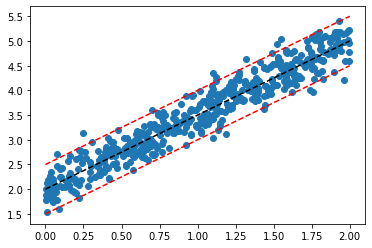

In [8]:
plt.scatter(X_train,y_train[:,0])

f_x = a*x_grid + b  

_delta = 2.0*_sigma  # 2 sigmas

print(f"delta: {_delta:.2f}")

plt.plot(x_grid, f_x, 'k--') # regression line
plt.plot(x_grid, f_x + _delta, 'r--') # upper boundary prediction
plt.plot(x_grid, f_x - _delta, 'r--') # lower boundary prediction

In [9]:
# hyperparameters
lambda_ = 0.01 # lambda in loss fn
alpha_ = 0.30  # capturing (1-alpha)% of samples
soften_ = 160.
n_ = n_samples # batch size

n_

def loss_qd(y_true, y_pred):

    return qd_objective(y_true, y_pred,n_, lambda_, alpha_, soften_)


def picp_metric_(y_true, y_pred):
    
    return picp_metric(y_true, y_pred, soften_=soften_)

def coverage_term_metric(y_true, y_pred):
    
    y_true = y_true[:,0]

    y_u = y_pred[:,0]
    y_l = y_pred[:,1]

    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)
    
    PICP_S = tf.reduce_mean(K_S)

    coverage_term = lambda_ * n_ / (alpha_*(1-alpha_)) * tf.maximum(0.,(1-alpha_) - PICP_S)
    
    return coverage_term

500

In [10]:
# set up model
model = Sequential()
model.add(Dense(100, input_dim=1, activation='relu',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)))
model.add(Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3), 
                bias_initializer=keras.initializers.Constant(value=[2.0,1.0]))) # important to init biases to start!

# compile
opt = keras.optimizers.Adam(lr=0.02, decay=0.005)
model.compile(loss=qd_objective, optimizer=opt, metrics=[mpiw_metric,coverage_term_metric,picp_metric_])

Text(0.5, 1.0, 'BEFORE training')

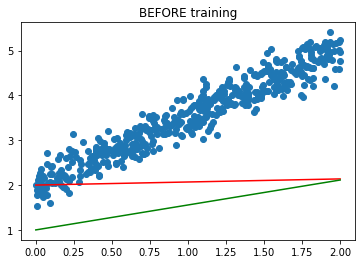

In [11]:
# plot and view some predictions
y_pred = model.predict(x_grid, verbose=0)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]

plt.scatter(X_train,y_train[:,0])
plt.plot(x_grid, y_u_pred, color='r') # upper boundary prediction
plt.plot(x_grid, y_l_pred, color='g') # lower boundary prediction
plt.title('BEFORE training')
#plt.xlim(-2,2)
plt.show()

In [12]:
%%time
result = model.fit(X_train, y_train, epochs=5, batch_size=n_, verbose=1,  validation_split=0.)

Epoch 1/5
1/1 [==============================] - 0s 1ms/step - loss: 20.1852 - mpiw_metric: 0.9616 - coverage_term_metric: 15.7885 - picp_metric_: 0.0369
Epoch 2/5
1/1 [==============================] - 0s 856us/step - loss: 18.7508 - mpiw_metric: 1.0789 - coverage_term_metric: 14.0338 - picp_metric_: 0.1106
Epoch 3/5
1/1 [==============================] - 0s 779us/step - loss: 15.0996 - mpiw_metric: 1.2448 - coverage_term_metric: 9.7168 - picp_metric_: 0.2919
Epoch 4/5
1/1 [==============================] - 0s 719us/step - loss: 4.3062 - mpiw_metric: 1.5726 - coverage_term_metric: 0.0000e+00 - picp_metric_: 0.8202
Epoch 5/5
1/1 [==============================] - 0s 790us/step - loss: 1.9956 - mpiw_metric: 1.9956 - coverage_term_metric: 0.0000e+00 - picp_metric_: 1.0000
CPU times: user 560 ms, sys: 29.9 ms, total: 589 ms
Wall time: 617 ms


0 => loss: 0.982 = 0.982 +  0.000; picp: 0.95 
preditcion intervals


Text(0.5, 1.0, 'AFTER training 1 epochs')

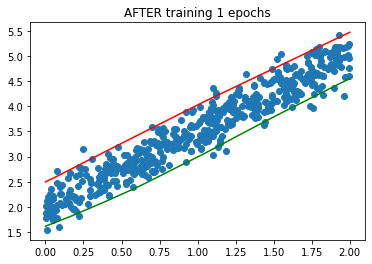

2 => loss: 1.012 = 1.012 +  0.000; picp: 0.96 
preditcion intervals


Text(0.5, 1.0, 'AFTER training 3 epochs')

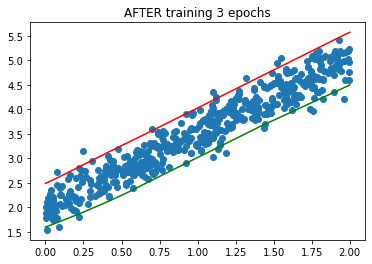

4 => loss: 1.016 = 1.016 +  0.000; picp: 0.94 
preditcion intervals


Text(0.5, 1.0, 'AFTER training 5 epochs')

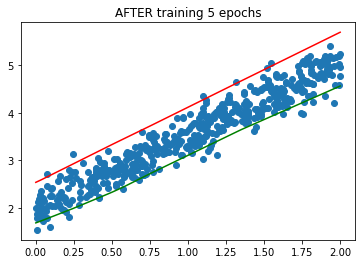

6 => loss: 1.005 = 1.005 +  0.000; picp: 0.95 
preditcion intervals


Text(0.5, 1.0, 'AFTER training 7 epochs')

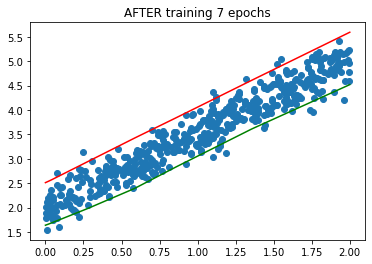

8 => loss: 0.974 = 0.974 +  0.000; picp: 0.95 
preditcion intervals


Text(0.5, 1.0, 'AFTER training 9 epochs')

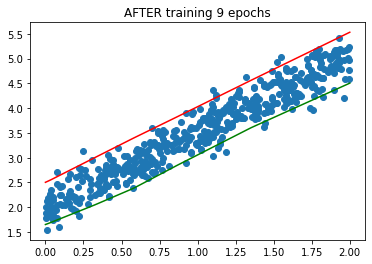

In [13]:

#result = model.fit(X_train, y_train, epochs=11, batch_size=n_, verbose=1,  validation_split=0.)
result_loss=[]
mpiw_list = []
coverage_list = []
loss_list = []
pcip_list = []
for i in range(10):
    
    result = model.fit(X_train, y_train, epochs=100, batch_size=n_, verbose=0,  validation_split=0.)
    result_loss.append(result.history['loss'])

    y_pred = model.predict(X_train, verbose=0)
        
    l = loss_qd(y_train, y_pred).numpy()
    loss_list.append(l)
    m = mpiw_metric(y_train, y_pred).numpy()
    mpiw_list.append(m)
    c = coverage_term_metric(y_train, y_pred).numpy()
    coverage_list.append(c)
    p = picp_metric_(y_train, y_pred).numpy()
    pcip_list.append(p)
    
    if i % 2 == 0:
    
        print(f"{i} => loss: {l:.3f} = {m:.3f} +  {c:.3f}; picp: {p:.2f} ")
    
        print("preditcion intervals")
        # plot and view some predictions
        y_pred = model.predict(x_grid, verbose=0)
        y_u_pred = y_pred[:,0]
        y_l_pred = y_pred[:,1]

        plt.scatter(X_train,y_train[:,0])
        plt.plot(x_grid, y_u_pred, color='r') # upper boundary prediction
        plt.plot(x_grid, y_l_pred, color='g') # lower boundary prediction
        plt.title('AFTER training '+str(len(result_loss))+' epochs')
        #plt.xlim(0,1.0)
        plt.show()    

In [111]:
K.set_value(model.optimizer.lr, 0.00001)
K.set_value(model.optimizer.decay, 0.005)

loss last 5 values: [0.21333967 0.21986106 0.22540587 0.23008184 0.23380809]


Text(0.5, 1.0, 'Loss')

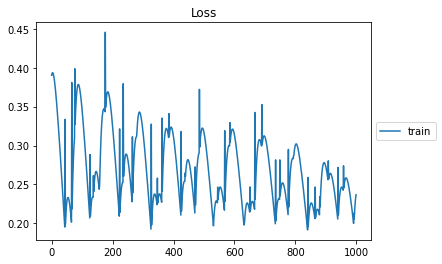

In [112]:
# view training
result_loss = np.array(result_loss).reshape(-1)

print(f"loss last 5 values: {result_loss[-6:-1]}")

x = range(result_loss.shape[0])
plt.plot(x, result_loss, label='train')
plt.title('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim(0,10)
plt.show()

array([2.53501  , 2.565626 , 2.5962002, 2.6267745, 2.6573489],
      dtype=float32)

array([1.4159956, 1.4452981, 1.4753579, 1.5054178, 1.5354776],
      dtype=float32)

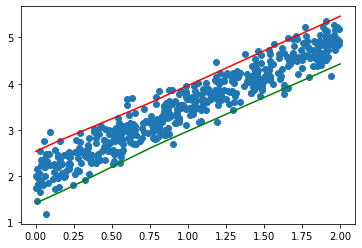

In [102]:
# plot and view some predictions
y_pred = model.predict(x_grid, verbose=0)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]

y_u_pred[0:5]
y_l_pred[0:5]

plt.scatter(X_train,y_train[:,0])
plt.plot(x_grid, y_u_pred, color='r') # upper boundary prediction
plt.plot(x_grid, y_l_pred, color='g') # lower boundary prediction
#plt.xlim(-2,2)
plt.show()